In [21]:
import numpy as np
import h5py
import glob, os, re, sys

from scipy.signal import savgol_filter as sg
from scipy import stats
from scipy.stats import gaussian_kde
from scipy import interpolate

import density_contours

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import gridspec
from matplotlib import cm
from matplotlib import ticker
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
import matplotlib.patches as patches
import matplotlib.font_manager as fm
fontprops = fm.FontProperties(size=20)
import matplotlib.colors as mplcolors
from matplotlib.colors import LogNorm
from matplotlib.lines import Line2D

In [22]:
# Plotting properties
grey = '#3C3C3C'
from matplotlib import rc
mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.weight'] = 'normal'
mpl.rcParams['xtick.major.pad'] = 5
mpl.rcParams['ytick.major.pad'] = 5
mpl.rcParams['axes.labelpad'] = 10
mpl.rcParams['font.size'] = 20
mpl.rcParams['legend.fontsize'] = 20
mpl.rcParams['legend.numpoints'] = 1
mpl.rcParams['savefig.dpi'] = 100
mpl.rcParams['mathtext.default'] = 'regular'
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['xtick.color'] = grey
mpl.rcParams['ytick.color'] = grey
mpl.rcParams['axes.edgecolor'] = grey
mpl.rcParams['axes.labelcolor'] = grey
rc('axes', linewidth=1.5)
rc('axes', edgecolor=grey)
labels_font = {'size':'20'} 

In [3]:
Msol_to_g = 1.99E33
Myr_to_s = 3.16E13
Gyr_to_s = 3.16E16
yr_to_s = 3.16E7
pc_to_cm = 3.086E18
kpc_to_cm = 3.086E21
kms_to_cms = 1.E5
G_cgs = 6.67E-8
kB_cgs = 1.38E-16
gamma = 5./3.
mu = 1.4
mp_cgs = 1.67e-24

In [4]:
def flatten_list(lst):
    if type(lst[0])==list:
        return [item for sublist in lst for item in sublist]
    else:
        return lst

In [5]:
def fitPlaneLTSQ(XYZ):
    (rows, cols) = XYZ.shape
    G = np.ones((rows, 3))
    G[:, 0] = XYZ[:, 0]  # X
    G[:, 1] = XYZ[:, 1]  # Y
    Z = XYZ[:, 2]
    (a, b, c),resid,rank,s = np.linalg.lstsq(G, Z)
    normal = (a, b, -1)
    nn = np.linalg.norm(normal)
    normal = normal / nn
    print(a,b,c)
    return (c, normal)

# pressures, weights, SFRs as a function of galactocentric radius (ETGs)

In [6]:
# snapshot to analyse
Rmin, Rmax = 0.3, 1.5
folders = ['ETGs/vlM-output', 'ETGs/lowM-output', 'ETGs/medM-output', 'ETGs/hiM-output']
minno, maxno = 100, 400

In [7]:
Rmin, Rmax = 0.3, 1.5
Rbinno = int(np.rint((Rmax-Rmin)/(0.2)))
Rbin_edges = np.linspace(Rmin, Rmax, Rbinno+1) * kpc_to_cm
Rbin_centres = (Rbin_edges[1:]+Rbin_edges[:-1])/2.

phibinno = 8
phibin_edges = np.linspace(-np.pi, np.pi, phibinno+1)
phibin_centres = (phibin_edges[1:]+phibin_edges[:-1])/2.
areas = np.zeros((Rbinno, phibinno))
for i in range(phibinno):
    areas[:,i] = np.pi*(Rbin_edges[1:]**2-Rbin_edges[:-1]**2)/phibinno

zbinno = 60
zbin_edges = np.linspace(-300., 300., zbinno+1) * pc_to_cm # 100-pc slices
zbin_centres = (zbin_edges[1:]+zbin_edges[:-1])/2.
deltaz = 600.*pc_to_cm/zbinno

R_grid, phi_grid, z_grid = np.meshgrid(Rbin_centres, phibin_centres, zbin_centres)

In [8]:
# load arrays
medPtots, q1Ptots, q4Ptots = [], [], []
for folder in folders:
    Pturbs = np.zeros((Rbinno, phibinno, maxno-minno))
    Pths = np.zeros((Rbinno, phibinno, maxno-minno))
    for no in range(minno, maxno):
        Pturbs[:,:,no-minno] = np.load(
            "/n/holystore01/LABS/itc_lab/Users/sjeffreson/"+folder+
            "/saved-arrays/rotcurve-data-avir-0.5kpc-Pturbs_"+str(no)+".npy",
            allow_pickle=True
        )
        Pths[:,:,no-minno] = np.load(
            "/n/holystore01/LABS/itc_lab/Users/sjeffreson/"+folder+
            "/saved-arrays/rotcurve-data-avir-0.5kpc-Pths_"+str(no)+".npy",
            allow_pickle=True
        )
    
    medPtots.append(np.median(Pths+Pturbs, axis=(1,2)))
    q1Ptots.append(np.percentile(Pths+Pturbs, 25, axis=(1,2)))
    q4Ptots.append(np.percentile(Pths+Pturbs, 75, axis=(1,2)))

In [9]:
medrhomaxs, q1rhomaxs, q4rhomaxs = [], [], []
for folder in folders:
    ptls = sorted(glob.glob(os.path.join(
        "/n/holystore01/LABS/itc_lab/Users/sjeffreson/"+folder+"/saved-arrays/ptl_*.npy")))
    ptlnos = [ptl.rsplit('ptl_')[1].rsplit('.npy')[0] for ptl in ptls]
    
    rhomaxs = np.zeros((Rbinno, phibinno, len(ptlnos)))
    for ptlno, i in zip(ptlnos, range(len(ptlnos))):
        rho3D = np.load(
            "/n/holystore01/LABS/itc_lab/Users/sjeffreson/"+folder+
            "/saved-arrays/rotcurve-data-avir-0.5kpc-rho3Ds_"+str(ptlno)+".npy",
            allow_pickle=True
        )
        # swap the axes of rho3D so R is first
        rhomaxs[:,:,i] = np.nanmax(rho3D, axis=2)
                
    medrhomaxs.append(np.median(rhomaxs, axis=(1,2)))
    q1rhomaxs.append(np.percentile(rhomaxs, 25, axis=(1,2)))
    q4rhomaxs.append(np.percentile(rhomaxs, 75, axis=(1,2)))

In [10]:
# load Omegas and betas
from scipy.interpolate import interp1d

Omegas, betas = [], []
for folder in folders:
    data = np.genfromtxt(
        "/n/holystore01/LABS/itc_lab/Users/sjeffreson/"+folder+"/saved-arrays/Omegazs_399.txt")
    Rs_ = data.T[0]
    Omegas_ = data.T[2]
    vcs_ = data.T[1]

    # get betas
    # get omega and beta
    logvcs_ = np.log10(vcs_)

    # find window length to equal scale-height
    polyno = 2
    wndwlen = 3

    dR = sg(Rs_, wndwlen, polyno, deriv=1)
    dvc = sg(vcs_, wndwlen, polyno, deriv=1)
    betas_ = dvc/dR * Rs_/vcs_

    fOmegas = interp1d(Rs_, Omegas_, bounds_error=False, fill_value=(Omegas_[0], Omegas_[-1]))
    fbetas = interp1d(Rs_, betas_, bounds_error=False, fill_value=(betas_[0], betas_[-1]))

    Omegas.append(fOmegas(Rbin_centres))
    betas.append(fbetas(Rbin_centres))

/tmp/ipykernel_1021597/2016802899.py:2: RuntimeWarning: invalid value encountered in log10
  plt.scatter(np.log10(medrhomaxs_/mp_cgs-0.25*Omegas_**2/4./np.pi/G_cgs/mp_cgs), np.log10(medPtots_), lw=3)


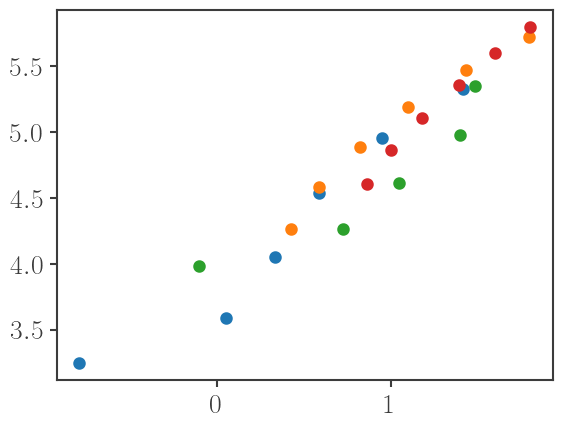

In [11]:
for medPtots_, medrhomaxs_, betas_, Omegas_ in zip(medPtots, medrhomaxs, betas, Omegas):
    plt.scatter(np.log10(medrhomaxs_/mp_cgs-0.25*Omegas_**2/4./np.pi/G_cgs/mp_cgs), np.log10(medPtots_), lw=3)
    #plt.scatter(medrhomaxs_/mp_cgs, 2.*Omegas_**2/4./np.pi/G_cgs/mp_cgs, lw=3)
#plt.plot(np.linspace(0., 100., 30), np.linspace(0., 100., 30))
plt.show()

# Milky Way

In [12]:
folders = ['MW-tracers']
MWRmin, MWRmax = 0.3, 13.
MWRbinno = int(np.rint((MWRmax-MWRmin)/(0.2)))
MWRbin_edges = np.linspace(MWRmin, MWRmax, MWRbinno+1) * kpc_to_cm
MWRbin_centres = (MWRbin_edges[1:]+MWRbin_edges[:-1])/2.

MWphibinno = 8

In [13]:
MWmedPtots, MWq1Ptots, MWq4Ptots = [], [], []
for folder in folders:
    rcs = sorted(glob.glob(os.path.join(
        "/n/holystore01/LABS/itc_lab/Users/sjeffreson/"+folder+"/saved-arrays/rotcurve-data-avir-0.5kpc-Pturbs-Tthresh_*.npy")))
    rcnos = [rc.rsplit('rotcurve-data-avir-0.5kpc-Pturbs-Tthresh_')[1].rsplit('.npy')[0] for rc in rcs]
    print(rcnos)
    
    Pturbs = np.zeros((MWRbinno, MWphibinno, len(rcnos)))
    Pths = np.zeros((MWRbinno, MWphibinno, len(rcnos)))
    for no, i in zip(rcnos, range(len(rcnos))):
        Pturbs[:,:,i] = np.load(
            "/n/holystore01/LABS/itc_lab/Users/sjeffreson/"+folder+
            "/saved-arrays/rotcurve-data-avir-0.5kpc-Pturbs-Tthresh_"+str(no)+".npy",
            allow_pickle=True
        )/1.5
        Pths[:,:,i] = np.load(
            "/n/holystore01/LABS/itc_lab/Users/sjeffreson/"+folder+
            "/saved-arrays/rotcurve-data-avir-0.5kpc-Pths-Tthresh_"+str(no)+".npy",
            allow_pickle=True
        )
    # take median over the time and phi axes simultaneously
    MWmedPtots.append(np.median(Pths+Pturbs, axis=(1,2)))
    MWq1Ptots.append(np.percentile(Pths+Pturbs, 25, axis=(1,2)))
    MWq4Ptots.append(np.percentile(Pths+Pturbs, 75, axis=(1,2)))

['300', '301', '302', '303', '304', '305', '306', '307', '308', '309', '310', '311', '312', '313', '314', '315', '316', '317', '318', '319', '320', '321', '322', '323', '324', '325', '326', '327', '328', '329', '330', '331', '332', '333', '334', '335', '336', '337', '338', '339', '340', '341', '342', '343', '344', '345', '346', '347', '348', '349', '350', '351', '352', '353', '354', '355', '356', '357', '358', '359', '360', '361', '362', '363', '364', '365', '366', '367', '368', '369', '370', '371', '372', '373', '374', '375', '376', '377', '378', '379', '380', '381', '382', '383', '384', '385', '386', '387', '388', '389', '390', '391', '392', '393', '394', '395', '396', '397', '398', '399', '400', '401', '402', '403', '404', '405', '406', '407', '408', '409', '410', '411', '412', '413', '414', '415', '416', '417', '418', '419', '420', '421', '422', '423', '424', '425', '426', '427', '428', '429', '430', '431', '432', '433', '434', '435', '436', '437', '438', '439', '440', '441', '442'

In [14]:
MWmedrhomaxs, MWq1rhomaxs, MWq4rhomaxs = [], [], []
for folder in folders:
    ptls = sorted(glob.glob(os.path.join(
        "/n/holystore01/LABS/itc_lab/Users/sjeffreson/"+folder+"/saved-arrays/rho3Ds-MW-NGC300-eEoS_*.npy")))
    ptlnos = [ptl.rsplit('rho3Ds-MW-NGC300-eEoS_')[1].rsplit('.npy')[0] for ptl in ptls]
    
    rhomaxs = np.zeros((MWRbinno, len(ptlnos)))
    for ptlno, i in zip(ptlnos, range(len(ptlnos))):
        rho3D = np.load(
            "/n/holystore01/LABS/itc_lab/Users/sjeffreson/"+folder+
            "/saved-arrays/rho3Ds-MW-NGC300-eEoS_"+str(ptlno)+".npy",
            allow_pickle=True
        )
        print(np.shape(rho3D))
        rhomaxs[:,i] = np.nanmax(rho3D, axis=(1,2))
    print(np.shape(rhomaxs))
    MWmedrhomaxs.append(np.median(rhomaxs, axis=1))
    MWq1rhomaxs.append(np.percentile(rhomaxs, 25, axis=1))
    MWq4rhomaxs.append(np.percentile(rhomaxs, 75, axis=1))

(63, 1, 60)
(63, 1, 60)
(63, 2)


In [15]:
MWOmegas, MWbetas = [], []
for folder in folders:
    data = np.genfromtxt(
        "/n/holystore01/LABS/itc_lab/Users/sjeffreson/"+folder+"/saved-arrays/Omegazs_600.txt")
    Rs_ = data.T[0]
    Omegas_ = data.T[2]
    vcs_ = data.T[1]

    # get betas
    # get omega and beta
    logvcs_ = np.log10(vcs_)

    # find window length to equal scale-height
    polyno = 2
    wndwlen = 3

    dR = sg(Rs_, wndwlen, polyno, deriv=1)
    dvc = sg(vcs_, wndwlen, polyno, deriv=1)
    betas_ = dvc/dR * Rs_/vcs_

    fOmegas = interp1d(Rs_, Omegas_, bounds_error=False, fill_value=(Omegas_[0], Omegas_[-1]))
    fbetas = interp1d(Rs_, betas_, bounds_error=False, fill_value=(betas_[0], betas_[-1]))

    MWOmegas.append(fOmegas(MWRbin_centres))
    MWbetas.append(fbetas(MWRbin_centres))

/tmp/ipykernel_1021597/2264664868.py:2: RuntimeWarning: invalid value encountered in log10
  plt.scatter(np.log10(medrhomaxs_/mp_cgs-2.*betas_*Omegas_**2/4./np.pi/G_cgs/mp_cgs), np.log10(medPtots_), lw=3)
/tmp/ipykernel_1021597/2264664868.py:3: RuntimeWarning: invalid value encountered in log10
  plt.scatter(np.log10(MWmedrhomaxs[0]/mp_cgs-2.*MWbetas[0]*MWOmegas[0]**2/4./np.pi/G_cgs/mp_cgs), np.log10(MWmedPtots[0]), lw=3)


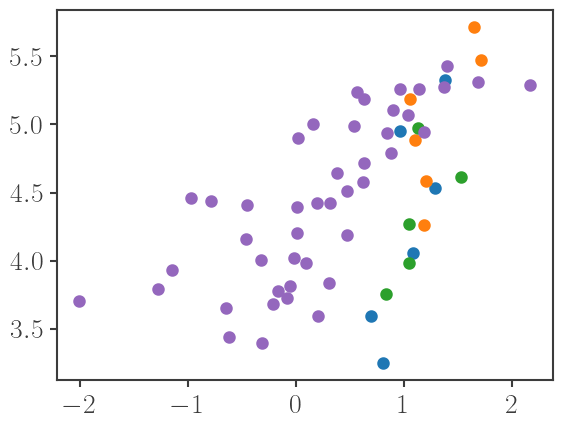

In [16]:
for medPtots_, medrhomaxs_, Omegas_, betas_ in zip(medPtots, medrhomaxs, Omegas, betas):
    plt.scatter(np.log10(medrhomaxs_/mp_cgs-2.*betas_*Omegas_**2/4./np.pi/G_cgs/mp_cgs), np.log10(medPtots_), lw=3)
plt.scatter(np.log10(MWmedrhomaxs[0]/mp_cgs-2.*MWbetas[0]*MWOmegas[0]**2/4./np.pi/G_cgs/mp_cgs), np.log10(MWmedPtots[0]), lw=3)
#plt.plot(np.linspace(-1.65, 2., 30), np.linspace(2., 7., 30))
#plt.xlim([-2., 2.])
#plt.ylim([2., 7.])
plt.show()

# NGC300

In [17]:
folders = ['NGC300']
NGC300Rmin, NGC300Rmax = 0.3, 6.
NGC300Rbinno = int(np.rint((NGC300Rmax-NGC300Rmin)/(0.2)))
NGC300Rbin_edges =np.linspace(NGC300Rmin, NGC300Rmax, NGC300Rbinno+1) * kpc_to_cm
NGC300Rbin_centres = (NGC300Rbin_edges[1:]+NGC300Rbin_edges[:-1])/2.

NGC300phibinno = 8
NGC300areas = np.zeros((NGC300Rbinno, NGC300phibinno))
for i in range(NGC300phibinno):
    NGC300areas[:,i] = np.pi*(NGC300Rbin_edges[1:]**2-NGC300Rbin_edges[:-1]**2)/NGC300phibinno

zmin, zmax = -300., 300.
# zmin, zmax = -1500., 1500.
NGC300zbin_edges = np.linspace(zmin, zmax, zbinno+1) * pc_to_cm
NGC300zbin_centres = (NGC300zbin_edges[1:]+NGC300zbin_edges[:-1])/2.
NGC300deltaz = (zmax-zmin)/zbinno*pc_to_cm

NGC300R_grid, NGC300phi_grid, NGC300z_grid = np.meshgrid(NGC300Rbin_centres, phibin_centres, NGC300zbin_centres)

In [18]:
NGC300medPtots, NGC300q1Ptots, NGC300q4Ptots = [], [], []
for folder in folders:
    rcs = sorted(glob.glob(os.path.join(
        "/n/holystore01/LABS/itc_lab/Users/sjeffreson/"+folder+"/saved-arrays/rotcurve-data-avir-0.5kpc-Pturbs-Tthresh_*.npy")))
    rcnos = [rc.rsplit('rotcurve-data-avir-0.5kpc-Pturbs-Tthresh_')[1].rsplit('.npy')[0] for rc in rcs]
    print(rcnos)
    
    Pturbs = np.zeros((NGC300Rbinno, NGC300phibinno, len(rcnos)))
    Pths = np.zeros((NGC300Rbinno, NGC300phibinno, len(rcnos)))
    
    for no, i in zip(rcnos, range(len(rcnos))):
        Pturbs[:,:,i] = np.load(
            "/n/holystore01/LABS/itc_lab/Users/sjeffreson/"+folder+
            "/saved-arrays/rotcurve-data-avir-0.5kpc-Pturbs-Tthresh_"+str(no)+".npy",
            allow_pickle=True
        )
        Pths[:,:,i] = np.load(
            "/n/holystore01/LABS/itc_lab/Users/sjeffreson/"+folder+
            "/saved-arrays/rotcurve-data-avir-0.5kpc-Pths-Tthresh_"+str(no)+".npy",
            allow_pickle=True
        )
    
    # take median over the time and phi axes simultaneously
    NGC300medPtots.append(np.median(Pths+Pturbs, axis=(1,2)))
    NGC300q1Ptots.append(np.percentile(Pths+Pturbs, 25, axis=(1,2)))
    NGC300q4Ptots.append(np.percentile(Pths+Pturbs, 75, axis=(1,2)))

['500', '501', '502', '503', '504', '505', '506', '507', '508', '509', '510', '511', '512', '513', '514', '515', '516', '517', '518', '519', '520', '521', '522', '523', '524', '525', '526', '527', '528', '529', '530', '531', '532', '533', '534', '535', '536', '537', '538', '539', '540', '541', '542', '543', '544', '545', '546', '547', '548', '549', '550', '551', '552', '553', '554', '555', '556', '557', '558', '559', '560', '561', '562', '563', '564', '565', '566', '567', '568', '569', '570', '571', '572', '573', '574', '575', '576', '577', '578', '579', '580', '581', '582', '583', '584', '585', '586', '587', '588', '589', '590', '591', '592', '593', '594', '595', '596', '597', '598', '599', '600', '601', '602', '603', '604', '605', '606', '607', '608', '609', '610', '611', '612', '613', '614', '615', '616', '617', '618', '619', '620', '621', '622', '623', '624', '625', '626', '627', '628', '629', '630', '631', '632', '633', '634', '635', '636', '637', '638', '639', '640', '641', '642'

In [19]:
NGC300medrhomaxs, NGC300q1rhomaxs, NGC300q4rhomaxs = [], [], []
for folder in folders:
    ptls = sorted(glob.glob(os.path.join(
        "/n/holystore01/LABS/itc_lab/Users/sjeffreson/"+folder+"/saved-arrays/rho3Ds-MW-NGC300-eEoS_*.npy")))
    ptlnos = [ptl.rsplit('rho3Ds-MW-NGC300-eEoS_')[1].rsplit('.npy')[0] for ptl in ptls]
    
    rhomaxs = np.zeros((NGC300Rbinno, len(ptlnos)))
    for ptlno, i in zip(ptlnos, range(len(ptlnos))):
        rho3D = np.load(
            "/n/holystore01/LABS/itc_lab/Users/sjeffreson/"+folder+
            "/saved-arrays/rho3Ds-MW-NGC300-eEoS_"+str(ptlno)+".npy",
            allow_pickle=True
        )
        rhomaxs[:,i] = np.nanmax(rho3D, axis=(1,2))
    NGC300medrhomaxs.append(np.median(rhomaxs, axis=1))
    NGC300q1rhomaxs.append(np.percentile(rhomaxs, 25, axis=1))
    NGC300q4rhomaxs.append(np.percentile(rhomaxs, 75, axis=1))

In [20]:
NGC300Omegas, NGC300betas = [], []
for folder in folders:
    data = np.genfromtxt(
        "/n/holystore01/LABS/itc_lab/Users/sjeffreson/"+folder+"/saved-arrays/Omegazs_799.txt")
    Rs_ = data.T[0]
    Omegas_ = data.T[2]
    vcs_ = data.T[1]

    # get betas
    # get omega and beta
    logvcs_ = np.log10(vcs_)

    # find window length to equal scale-height
    polyno = 2
    wndwlen = 3

    dR = sg(Rs_, wndwlen, polyno, deriv=1)
    dvc = sg(vcs_, wndwlen, polyno, deriv=1)
    betas_ = dvc/dR * Rs_/vcs_

    fOmegas = interp1d(Rs_, Omegas_, bounds_error=False, fill_value=(Omegas_[0], Omegas_[-1]))
    fbetas = interp1d(Rs_, betas_, bounds_error=False, fill_value=(betas_[0], betas_[-1]))

    NGC300Omegas.append(fOmegas(NGC300Rbin_centres))
    NGC300betas.append(fbetas(NGC300Rbin_centres))

# 3D figure

/tmp/ipykernel_1021597/4209923792.py:38: MatplotlibDeprecationWarning: The dist attribute was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  ax0.dist = 12
/tmp/ipykernel_1021597/4209923792.py:39: MatplotlibDeprecationWarning: The dist attribute was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  ax1.dist = 12
/tmp/ipykernel_1021597/4209923792.py:40: MatplotlibDeprecationWarning: The dist attribute was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  ax2.dist = 12
/tmp/ipykernel_1021597/4209923792.py:56: RuntimeWarning: invalid value encountered in sqrt
  ax.scatter3D(np.log10((MWOmegas[0]*np.sqrt(2.*(1+MWbetas[0])))*Myr_to_s),
/tmp/ipykernel_1021597/4209923792.py:58: RuntimeWarning: invalid value encountered in sqrt
  ax.scatter3D(np.log10((NGC300Omegas[0]*np.sqrt(2.*(1+NGC300betas[0])))*Myr_to_s),
/tmp/ipykernel_1021597/4209923792.py:66: RuntimeWarning: invalid value encountered in sqrt
  list(MWOme

-0.3285295393852299 1.0034644391378977 3.935201273893892
-0.3285295393852299 1.0034644391378977 3.935201273893892
slope = 1.1409311221124476 intercept = 4.4245197700814725


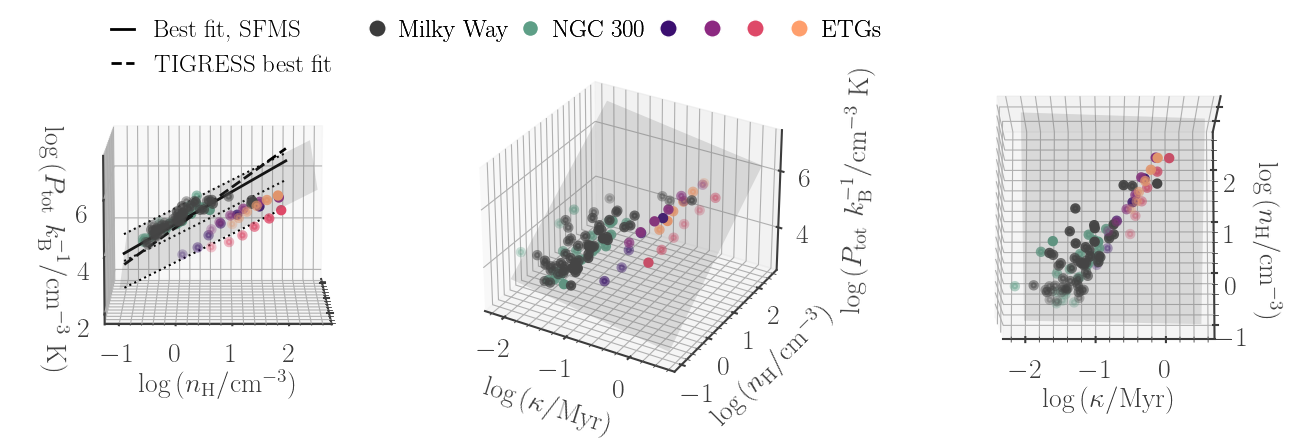

In [71]:
figW = 16
figH = 5
fig = plt.figure(figsize=(figW, figH))

topMarg = 0.1
leftMarg = 0.1
botMarg = 0.1
rightMarg = 0.1

wBetMarg = 0.02
hBetMarg = 0.01

crightMarg = 0.105
cW = 0.04
cBet = 0.02

h = (1.0-topMarg-botMarg)
w = (1.0-leftMarg-rightMarg-2*wBetMarg)/3

### axes ###
ax0 = fig.add_axes([leftMarg, botMarg, w, 2*h], projection='3d',
                    xticklabels='')
ax1 = fig.add_axes([leftMarg+w+0.3*wBetMarg, botMarg, w, 2*h], projection='3d')
ax2 = fig.add_axes([leftMarg+2.*w+2.5*wBetMarg, botMarg, w, 2*h], projection='3d',
                    xlabel=r'$\log{(\kappa/{\rm Myr})}$',
                    ylabel=r'$\log{(n_{\rm H}/{\rm cm}^{-3})}$',
                    zticklabels='')
ax2.view_init(80,-90)
ax0.view_init(10,0)
axs = [ax0, ax1, ax2]
ax0.set_ylabel(r'$\log{(n_{\rm H}/{\rm cm}^{-3})}$', labelpad=20)
ax0.set_zlabel(r'$\log{(P_{\rm tot}~k_{\rm B}^{-1}/{\rm cm}^{-3}~{\rm K})}$')
ax1.set_xlabel(r'$\log{(\kappa/{\rm Myr})}$', labelpad=20)
ax1.set_ylabel(r'$\log{(n_{\rm H}/{\rm cm}^{-3})}$', labelpad=15)
ax1.set_zlabel(r'$\log{(P_{\rm tot}~k_{\rm B}^{-1}/{\rm cm}^{-3}~{\rm K})}$', labelpad=20)
ax2.set_xlabel(r'$\log{(\kappa/{\rm Myr})}$', labelpad=20)
ax2.set_ylabel(r'$\log{(n_{\rm H}/{\rm cm}^{-3})}$', labelpad=20)
ax0.dist = 12
ax1.dist = 12
ax2.dist = 12

for ax in axs:
    ax.tick_params(axis = 'both', bottom = True, top = True, left = True, right = True,
                which = 'both', direction='in')
    ax.minorticks_on()

allmedPtots, allmedrhomaxs, allOmegas = [], [], []
for ax in axs:
    for i, medPtots_, medrhomaxs_, Omegas_, betas_ in zip(range(len(medPtots)), medPtots, medrhomaxs, Omegas, betas):
        if((i!=2) & (ax==ax0)):
            allmedPtots.append(list(medPtots_))
            allmedrhomaxs.append(list(medrhomaxs_))
            allOmegas.append(list(Omegas_*np.sqrt(2.*(1+betas_))*Myr_to_s))
        ax.scatter3D(np.log10((Omegas_*np.sqrt(2.*(1+betas_)))*Myr_to_s),
                     np.log10(medrhomaxs_/mp_cgs/1.4), np.log10(medPtots_), lw=3, color=plt.cm.magma(float(i+1)/5.))
    ax.scatter3D(np.log10((MWOmegas[0]*np.sqrt(2.*(1+MWbetas[0])))*Myr_to_s),
                 np.log10(MWmedrhomaxs[0]/mp_cgs/1.4), np.log10(MWmedPtots[0]), lw=3, color='#3C3C3C')
    ax.scatter3D(np.log10((NGC300Omegas[0]*np.sqrt(2.*(1+NGC300betas[0])))*Myr_to_s), 
                 np.log10(NGC300medrhomaxs[0]/mp_cgs/1.4), np.log10(NGC300medPtots[0]), lw=3, color='#5E9F87')
    allmedPtots = flatten_list(allmedPtots)
    allmedrhomaxs = flatten_list(allmedrhomaxs)
    allOmegas = flatten_list(allOmegas)

# fit plane to points
xpts = np.log10(np.array(
    list(MWOmegas[0]*np.sqrt(2.*(1+MWbetas[0]))*Myr_to_s)+
    list(NGC300Omegas[0]*np.sqrt(2.*(1+NGC300betas[0]))*Myr_to_s)+
    list(allOmegas)
))
ypts = np.log10(np.array(list(MWmedrhomaxs[0])+list(NGC300medrhomaxs[0])+list(allmedrhomaxs))/mp_cgs/1.4)
zpts = np.log10(np.array(list(MWmedPtots[0])+list(NGC300medPtots[0])+list(allmedPtots)))
cnd = ~np.isnan(xpts) & ~np.isnan(ypts) & ~np.isnan(zpts)
xpts = xpts[cnd]
ypts = ypts[cnd]
zpts = zpts[cnd]
data = np.array([xpts, ypts, zpts]).T
c, normal = fitPlaneLTSQ(data)

# plot fitted plane
maxx = 0.5#np.max(data[:,0])
maxy = 2.5#np.max(data[:,1])
minx = -2.#np.min(data[:,0])
miny = -1.#np.min(data[:,1])

point = np.array([0.0, 0.0, c])
d = -point.dot(normal)

# compute points needed for plane plotting
xx, yy = np.meshgrid([minx, maxx], [miny, maxy])
z = (-normal[0]*xx - normal[1]*yy - d)*1. / normal[2]
print(-normal[0]/normal[2], -normal[1]/normal[2], -d/normal[2])

# plot plane
ax0.plot_surface(xx, yy, z, alpha=0.2, color='grey')
ax1.plot_surface(xx, yy, z, alpha=0.2, color='grey')
ax2.plot_surface(xx, yy, z, alpha=0.2, color='grey')

# fit line to SFMS points
slope, intercept, r_value, p_value, std_err = stats.linregress(
    np.log10(np.array(list(MWmedrhomaxs[0])+list(NGC300medrhomaxs[0]))/mp_cgs/1.4),
    np.log10(np.array(list(MWmedPtots[0])+list(NGC300medPtots[0])))
)
print("slope = "+str(slope), "intercept = "+str(intercept))

# eEoS from TIGRESS
logxT = np.linspace(-1., 2., 30)
logyT = 1.43*logxT + 4.3
ax0.plot3D(-1.*np.ones(len(logxT)), logxT,  logyT, lw=2, color='black', ls='--', zorder=3)
ax0.plot3D(-1.*np.ones(len(logxT)), logxT,  slope*logxT+intercept, lw=2, color='black', zorder=3)
#ax1.plot3D(-1.*np.ones(len(logxT)), logxT,  logyT, lw=2, color='black', ls='--', zorder=3)

# isotherms
for logT in np.linspace(3,5,3):
       logyt = logT + logxT
       ax0.plot3D(-1.*np.ones(len(logxT)), logxT, logyt, zorder=0, color='k', ls='dotted')

# legend, sims
custom_lines = [Line2D([0], [0], marker='o', markerfacecolor='#3C3C3C',
                       markeredgecolor='white', markersize=12.5, lw=0),
                Line2D([0], [0], marker='o', markerfacecolor='#5E9F87', markeredgewidth=2,
                       markeredgecolor='white', markersize=12.5, lw=3),
                Line2D([0], [0], marker='o', markerfacecolor=plt.cm.magma(1./5.),
                       markeredgecolor='white', markersize=12.5, lw=0),
                Line2D([0], [0], marker='o', markerfacecolor=plt.cm.magma(2./5.),
                       markeredgecolor='white', markersize=12.5, lw=0),
                Line2D([0], [0], marker='o', markerfacecolor=plt.cm.magma(3./5.),
                       markeredgecolor='white', markersize=12.5, lw=0),
                Line2D([0], [0], marker='o', markerfacecolor=plt.cm.magma(4./5.),
                       markeredgecolor='white', markersize=12.5, lw=0)]
legend1 = ax1.legend(
    custom_lines, [r'Milky Way', r'NGC~300', r'', r'', r'', r'ETGs'], loc='lower center', bbox_to_anchor=(0.5, 0.9),
    ncol=6, frameon=False, handlelength=0.2, columnspacing=0.75, fontsize=18
)
ax1.add_artist(legend1)

custom_lines = [Line2D([0], [0], color='k', lw=2),
                Line2D([0], [0], color='k', lw=2, ls='--')]
legend2 = ax0.legend(
    custom_lines, ['Best fit, SFMS', 'TIGRESS best fit'], bbox_to_anchor=(0.85, 1.065),
    ncol=1, frameon=False, handlelength=0.9, columnspacing=0.75, fontsize=18
)

plt.savefig('/n/holystore01/LABS/itc_lab/Users/sjeffreson/ETGs/figs/eEoS_3D.pdf', bbox_inches='tight', format='pdf')
plt.show()

#  effective equation of state predicted at low resolution using SH03 for the MW and one of the ETGs

In [21]:
fs = [h5py.File('/n/holystore01/LABS/itc_lab/Users/sjeffreson/LtU/LOW-SH03/output/snap_040.hdf5', 'r')]
      #h5py.File('/n/holystore01/LABS/itc_lab/Users/sjeffreson/LtU/LOW-hiM-ETG/output/snap_040.hdf5', 'r')]

In [22]:
Ps, rhos = [], []
xs, ys = [], []
for f in fs:
    header = f['Header']
    gas = f['PartType0']
    rho = gas['Density'][:] * header.attrs['UnitMass_in_g'] / header.attrs['UnitLength_in_cm']**3
    U = gas['InternalEnergy'][:] * gas['InternalEnergy'].attrs['to_cgs']
    P = (gamma - 1.) * rho * U
    
    # no cut
    Ps.append(P)
    rhos.append(rho)

# figure

In [23]:
labels = [r"$\mathbf{M_*=10^{10}{\rm M}_\odot}$",
          r"$\mathbf{M_*=10^{10.5}{\rm M}_\odot}$",
          r"$\mathbf{M_*=10^{11}{\rm M}_\odot}$",
          r"$\mathbf{M_*=10^{11.5}{\rm M}_\odot}$",
          r"Milky Way-like",
          r"NGC~300-like"]

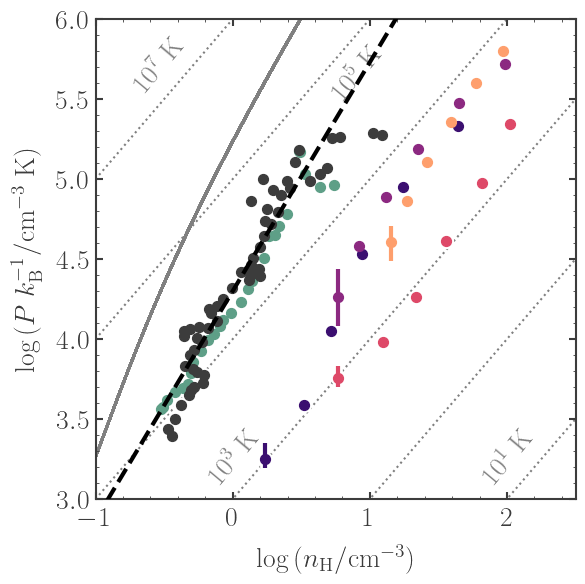

In [24]:
figW = 6
figH = 6
fig = plt.figure(figsize=(figW, figH))

topMarg = 0.1
leftMarg = 0.1
botMarg = 0.1
rightMarg = 0.1

wBetMarg = 0.03
hBetMarg = 0.01

crightMarg = 0.105
cW = 0.04
cBet = 0.02

h = (1.0-topMarg-botMarg)
w = (1.0-leftMarg-rightMarg)

### axes ###
ax0 = fig.add_axes([leftMarg, botMarg, w, h], xlim=[-1., 2.5], ylim=[3., 6.],
                  xlabel=r'$\log{(n_{\rm H}/{\rm cm}^{-3})}$',
                  ylabel=r'$\log{(P~k_{\rm B}^{-1}/{\rm cm}^{-3}~{\rm K})}$')

ax0.tick_params(axis = 'both', bottom = True, top = True, left = True, right = True,
              which = 'both', direction='in')
ax0.minorticks_on()

# sim data
# NGC300
ax0.scatter(np.log10(NGC300medrhomaxs[0]/mp_cgs),  np.log10(NGC300medPtots[0]), s=50, color='#5E9F87', zorder=3)
ax0.scatter(np.log10(NGC300medrhomaxs[0]/mp_cgs),  np.log10(NGC300medPtots[0]), s=100, color='white', zorder=2)

# one error bar
ax0.vlines(np.log10(NGC300medrhomaxs[0][-1]), np.log10(NGC300q1Ptots[0][-1]),
              ymax=np.log10(NGC300q4Ptots[0][-1]),
              lw=3, color='#5E9F87', zorder=3)
ax0.vlines(np.log10(NGC300medrhomaxs[0][-1]), np.log10(NGC300q1Ptots[0][-1]),
              ymax=np.log10(NGC300q4Ptots[0][-1]),
              lw=7, color='white', zorder=2)
ax0.hlines(np.log10(NGC300medPtots[0][-1]), np.log10(NGC300q1rhomaxs[0][-1]),
              xmax=np.log10(NGC300q4rhomaxs[0][-1]),
              lw=3, color='#5E9F87', zorder=3)
ax0.hlines(np.log10(NGC300medPtots[0][-1]), np.log10(NGC300q1rhomaxs[0][-1]),
              xmax=np.log10(NGC300q4rhomaxs[0][-1]),
              lw=7, color='white', zorder=2)

# MW
ax0.scatter(np.log10(MWmedrhomaxs[0][5:]/mp_cgs),  np.log10(MWmedPtots[0][5:]), s=50, color='#3C3C3C', zorder=3)
ax0.scatter(np.log10(MWmedrhomaxs[0][5:]/mp_cgs),  np.log10(MWmedPtots[0][5:]), s=100, color='white', zorder=2)

# one error bar
ax0.vlines(np.log10(MWmedrhomaxs[0][-1]), np.log10(MWq1Ptots[0][-1]),
              ymax=np.log10(MWq4Ptots[0][-1]),
              lw=3, color='#3C3C3C', zorder=3)
ax0.vlines(np.log10(MWmedrhomaxs[0][-1]), np.log10(MWq1Ptots[0][-1]),
              ymax=np.log10(MWq4Ptots[0][-1]),
              lw=7, color='white', zorder=2)
ax0.hlines(np.log10(MWmedPtots[0][-1]), np.log10(MWq1rhomaxs[0][-1]),
              xmax=np.log10(MWq4rhomaxs[0][-1]),
              lw=3, color='#3C3C3C', zorder=3)
ax0.hlines(np.log10(MWmedPtots[0][-1]), np.log10(MWq1rhomaxs[0][-1]),
              xmax=np.log10(MWq4rhomaxs[0][-1]),
              lw=7, color='white', zorder=2)

# ETGs
for medPtots_, medrhomaxs_, q1Ptots_, q4Ptots_, q1rhomaxs_, q4rhomaxs_, i in zip(medPtots, medrhomaxs, q1Ptots, q4Ptots, q1rhomaxs, q4rhomaxs, range(len(medPtots))):
       ax0.scatter(np.log10(medrhomaxs_/mp_cgs), np.log10(medPtots_), s=50, color=plt.cm.magma((i+1)/5.), zorder=3)
       ax0.scatter(np.log10(medrhomaxs_/mp_cgs), np.log10(medPtots_), s=100, color='white', zorder=2)
       
       # one error bar
       ax0.vlines(np.log10(medrhomaxs_[-1]/mp_cgs), np.log10(q1Ptots_[-1]),
                       ymax=np.log10(q4Ptots_[-1]),
                       lw=3, color=plt.cm.magma((i+1)/5.), zorder=3)
       ax0.vlines(np.log10(medrhomaxs_[-1]/mp_cgs), np.log10(q1Ptots_[-1]),
                       ymax=np.log10(q4Ptots_[-1]),
                       lw=7, color='white', zorder=2)
       ax0.hlines(np.log10(medPtots_[-1]), np.log10(q1rhomaxs_[-1]),
                       xmax=np.log10(q4rhomaxs_[-1]),
                       lw=3, color=plt.cm.magma((i+1)/5.), zorder=3)
       ax0.hlines(np.log10(medPtots_[-1]), np.log10(q1rhomaxs_[-1]),
                       xmax=np.log10(q4rhomaxs_[-1]),
                       lw=7, color='white', zorder=2)

# eEoS from TIGRESS
logxT = np.linspace(-1., 2.5, 30)
logyT = 1.43*logxT + 4.3
ax0.plot(logxT, logyT, lw=3, color='black', ls='--', zorder=3)

# isotherms
for logT in np.linspace(1,8,8):
       logyt = logT + logxT
       ax0.plot(logxT, logyt, zorder=0, color='k', ls='dotted', alpha=0.5)

# eEoS from SH03
ax0.scatter(np.log10(rhos[0][::5]/mp_cgs), np.log10(Ps[0][::5]/kB_cgs), s=0.5, zorder=0, color='grey')

# annotations of the isotherms, bottom right to top left at temperatures of 10, 1000 etc. K
ax0.text(1.8, 3.1, r'$10^1$ K', color='k', fontsize=20, rotation=50, alpha=0.5)
ax0.text(-0.2, 3.1, r'$10^3$ K', color='k', fontsize=20, rotation=50, alpha=0.5)
ax0.text(0.7, 5.5, r'$10^5$ K', color='k', fontsize=20, rotation=50, alpha=0.5)
ax0.text(-0.75, 5.55, r'$10^7$ K', color='k', fontsize=20, rotation=50, alpha=0.5)

# legend, sims
custom_lines = [Line2D([0], [0], marker='o', markerfacecolor=plt.cm.magma(1./5.),
                       markeredgecolor='white', markersize=12.5, lw=0),
                Line2D([0], [0], marker='o', markerfacecolor=plt.cm.magma(2./5.),
                       markeredgecolor='white', markersize=12.5, lw=0),
                Line2D([0], [0], marker='o', markerfacecolor=plt.cm.magma(3./5.),
                       markeredgecolor='white', markersize=12.5, lw=0),
                Line2D([0], [0], marker='o', markerfacecolor=plt.cm.magma(4./5.),
                       markeredgecolor='white', markersize=12.5, lw=0)]
legend1 = ax0.legend(
    custom_lines, [r'', r'', r'', r'ETG simulations'],
    loc='lower center', bbox_to_anchor=(0.5, 1.), ncol=6, frameon=False, handlelength=0.2, columnspacing=0.75
)
custom_lines = [Line2D([0], [0], marker='o', markerfacecolor='#3C3C3C',
                       markeredgecolor='white', markersize=12.5, lw=0),
                Line2D([0], [0], marker='o', markerfacecolor='#5E9F87', markeredgewidth=2,
                       markeredgecolor='white', markersize=12.5, lw=3)]
legend2 = ax0.legend(
    custom_lines, [r'Milky Way', r'NGC~300'], loc='lower center', bbox_to_anchor=(0.5, 1.12),
    ncol=2, frameon=False, handlelength=0.2, columnspacing=0.75
)
ax0.add_artist(legend1)
ax0.add_artist(legend2)

plt.savefig(
    '/n/holystore01/LABS/itc_lab/Users/sjeffreson/ETGs/figs/eEoS.pdf',
    bbox_inches='tight',
    format='pdf'
)

plt.show()

# black background

In [26]:
# Plotting properties
from matplotlib import rc
mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.weight'] = 'normal'
mpl.rcParams['xtick.major.pad'] = 5
mpl.rcParams['ytick.major.pad'] = 5
mpl.rcParams['axes.labelpad'] = 10
mpl.rcParams['font.size'] = 20
mpl.rcParams['legend.fontsize'] = 20
mpl.rcParams['legend.numpoints'] = 1
mpl.rcParams['savefig.dpi'] = 100
mpl.rcParams['mathtext.default'] = 'regular'
plt.rcParams['figure.facecolor'] = 'black'
mpl.rcParams['text.color'] = 'white'
mpl.rcParams['axes.labelcolor'] = 'white'
mpl.rcParams['axes.facecolor'] = 'black'
mpl.rcParams['axes.edgecolor'] = 'white'
mpl.rcParams['xtick.color'] = 'white'
mpl.rcParams['ytick.color'] = 'white'
labels_font = {'size':'20'}

cmap = plt.cm.pink
cmap.set_bad('black')

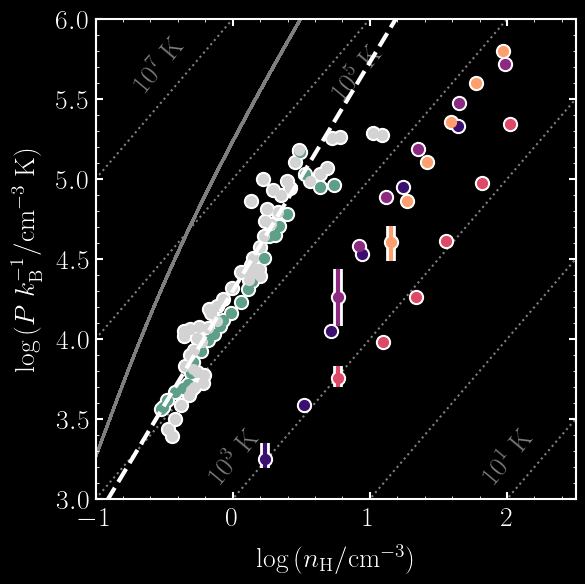

In [32]:
figW = 6
figH = 6
fig = plt.figure(figsize=(figW, figH))

topMarg = 0.1
leftMarg = 0.1
botMarg = 0.1
rightMarg = 0.1

wBetMarg = 0.03
hBetMarg = 0.01

crightMarg = 0.105
cW = 0.04
cBet = 0.02

h = (1.0-topMarg-botMarg)
w = (1.0-leftMarg-rightMarg)

### axes ###
ax0 = fig.add_axes([leftMarg, botMarg, w, h], xlim=[-1., 2.5], ylim=[3., 6.],
                  xlabel=r'$\log{(n_{\rm H}/{\rm cm}^{-3})}$',
                  ylabel=r'$\log{(P~k_{\rm B}^{-1}/{\rm cm}^{-3}~{\rm K})}$')

ax0.tick_params(axis = 'both', bottom = True, top = True, left = True, right = True,
              which = 'both', direction='in')
ax0.minorticks_on()

# sim data
# NGC300
ax0.scatter(np.log10(NGC300medrhomaxs[0]/mp_cgs),  np.log10(NGC300medPtots[0]), s=50, color='#5E9F87', zorder=3)
ax0.scatter(np.log10(NGC300medrhomaxs[0]/mp_cgs),  np.log10(NGC300medPtots[0]), s=100, color='white', zorder=2)

# one error bar
ax0.vlines(np.log10(NGC300medrhomaxs[0][-1]), np.log10(NGC300q1Ptots[0][-1]),
              ymax=np.log10(NGC300q4Ptots[0][-1]),
              lw=3, color='#5E9F87', zorder=3)
ax0.vlines(np.log10(NGC300medrhomaxs[0][-1]), np.log10(NGC300q1Ptots[0][-1]),
              ymax=np.log10(NGC300q4Ptots[0][-1]),
              lw=7, color='white', zorder=2)
ax0.hlines(np.log10(NGC300medPtots[0][-1]), np.log10(NGC300q1rhomaxs[0][-1]),
              xmax=np.log10(NGC300q4rhomaxs[0][-1]),
              lw=3, color='#5E9F87', zorder=3)
ax0.hlines(np.log10(NGC300medPtots[0][-1]), np.log10(NGC300q1rhomaxs[0][-1]),
              xmax=np.log10(NGC300q4rhomaxs[0][-1]),
              lw=7, color='white', zorder=2)

# MW
ax0.scatter(np.log10(MWmedrhomaxs[0][5:]/mp_cgs),  np.log10(MWmedPtots[0][5:]), s=50, color='lightgrey', zorder=3)
ax0.scatter(np.log10(MWmedrhomaxs[0][5:]/mp_cgs),  np.log10(MWmedPtots[0][5:]), s=100, color='white', zorder=2)

# one error bar
ax0.vlines(np.log10(MWmedrhomaxs[0][-1]), np.log10(MWq1Ptots[0][-1]),
              ymax=np.log10(MWq4Ptots[0][-1]),
              lw=3, color='lightgrey', zorder=3)
ax0.vlines(np.log10(MWmedrhomaxs[0][-1]), np.log10(MWq1Ptots[0][-1]),
              ymax=np.log10(MWq4Ptots[0][-1]),
              lw=7, color='white', zorder=2)
ax0.hlines(np.log10(MWmedPtots[0][-1]), np.log10(MWq1rhomaxs[0][-1]),
              xmax=np.log10(MWq4rhomaxs[0][-1]),
              lw=3, color='lightgrey', zorder=3)
ax0.hlines(np.log10(MWmedPtots[0][-1]), np.log10(MWq1rhomaxs[0][-1]),
              xmax=np.log10(MWq4rhomaxs[0][-1]),
              lw=7, color='white', zorder=2)

# ETGs
for medPtots_, medrhomaxs_, q1Ptots_, q4Ptots_, q1rhomaxs_, q4rhomaxs_, i in zip(medPtots, medrhomaxs, q1Ptots, q4Ptots, q1rhomaxs, q4rhomaxs, range(len(medPtots))):
       ax0.scatter(np.log10(medrhomaxs_/mp_cgs), np.log10(medPtots_), s=50, color=plt.cm.magma((i+1)/5.), zorder=3)
       ax0.scatter(np.log10(medrhomaxs_/mp_cgs), np.log10(medPtots_), s=100, color='white', zorder=2)
       
       # one error bar
       ax0.vlines(np.log10(medrhomaxs_[-1]/mp_cgs), np.log10(q1Ptots_[-1]),
                       ymax=np.log10(q4Ptots_[-1]),
                       lw=3, color=plt.cm.magma((i+1)/5.), zorder=3)
       ax0.vlines(np.log10(medrhomaxs_[-1]/mp_cgs), np.log10(q1Ptots_[-1]),
                       ymax=np.log10(q4Ptots_[-1]),
                       lw=7, color='white', zorder=2)
       ax0.hlines(np.log10(medPtots_[-1]), np.log10(q1rhomaxs_[-1]),
                       xmax=np.log10(q4rhomaxs_[-1]),
                       lw=3, color=plt.cm.magma((i+1)/5.), zorder=3)
       ax0.hlines(np.log10(medPtots_[-1]), np.log10(q1rhomaxs_[-1]),
                       xmax=np.log10(q4rhomaxs_[-1]),
                       lw=7, color='white', zorder=2)

# eEoS from TIGRESS
logxT = np.linspace(-1., 2.5, 30)
logyT = 1.43*logxT + 4.3
ax0.plot(logxT, logyT, lw=3, color='white', ls='--', zorder=3)

# isotherms
for logT in np.linspace(1,8,8):
       logyt = logT + logxT
       ax0.plot(logxT, logyt, zorder=0, color='white', ls='dotted', alpha=0.5)

# eEoS from SH03
ax0.scatter(np.log10(rhos[0][::5]/mp_cgs), np.log10(Ps[0][::5]/kB_cgs), s=0.5, zorder=0, color='grey')

# annotations of the isotherms, bottom right to top left at temperatures of 10, 1000 etc. K
ax0.text(1.8, 3.1, r'$10^1$ K', color='white', fontsize=20, rotation=50, alpha=0.5)
ax0.text(-0.2, 3.1, r'$10^3$ K', color='white', fontsize=20, rotation=50, alpha=0.5)
ax0.text(0.7, 5.5, r'$10^5$ K', color='white', fontsize=20, rotation=50, alpha=0.5)
ax0.text(-0.75, 5.55, r'$10^7$ K', color='white', fontsize=20, rotation=50, alpha=0.5)

# legend, sims
custom_lines = [Line2D([0], [0], marker='o', markerfacecolor=plt.cm.magma(1./5.),
                       markeredgecolor='white', markersize=12.5, lw=0),
                Line2D([0], [0], marker='o', markerfacecolor=plt.cm.magma(2./5.),
                       markeredgecolor='white', markersize=12.5, lw=0),
                Line2D([0], [0], marker='o', markerfacecolor=plt.cm.magma(3./5.),
                       markeredgecolor='white', markersize=12.5, lw=0),
                Line2D([0], [0], marker='o', markerfacecolor=plt.cm.magma(4./5.),
                       markeredgecolor='white', markersize=12.5, lw=0)]
legend1 = ax0.legend(
    custom_lines, [r'', r'', r'', r'ETG simulations'],
    loc='lower center', bbox_to_anchor=(0.5, 1.), ncol=6, frameon=False, handlelength=0.2, columnspacing=0.75
)
custom_lines = [Line2D([0], [0], marker='o', markerfacecolor='white',
                       markeredgecolor='white', markersize=12.5, lw=0),
                Line2D([0], [0], marker='o', markerfacecolor='#5E9F87', markeredgewidth=2,
                       markeredgecolor='white', markersize=12.5, lw=3)]
legend2 = ax0.legend(
    custom_lines, [r'Milky Way', r'NGC~300'], loc='lower center', bbox_to_anchor=(0.5, 1.12),
    ncol=2, frameon=False, handlelength=0.2, columnspacing=0.75
)
ax0.add_artist(legend1)
ax0.add_artist(legend2)

plt.savefig(
    '/n/holystore01/LABS/itc_lab/Users/sjeffreson/ETGs/figs/eEoS-bb.pdf',
    bbox_inches='tight',
    format='pdf'
)

plt.show()